In [22]:
import os
import time
import pickle
import sqlite3
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

In [2]:
def folderChecker(my_folder='./my_folder'):
    ## ------- simply clean up the folder path -------
    if my_folder is None:
        my_folder='./tmp'
    elif '/' not in my_folder:
        my_folder = os.path.join(os.getcwd(), my_folder)

    ## ------- Check if the folder exists -------
    check_folder = os.path.isdir(my_folder)
    # os.path.exists(dir_outputs)
    # If the folder does not exist, create it
    if not check_folder:
        os.makedirs(my_folder)
        print(f"\tCreated folder: {my_folder}")
    else:
        print(f'\t{my_folder} is existing')

    return my_folder

In [3]:
##############################################################################################
############################### Loading data from database ###################################
##############################################################################################
def _call_my_query(db_file, my_query):
    import sqlite3
    
    ## connect to the SQLIte database
    my_connection = sqlite3.connect(db_file)

    ## create a cursor object
    my_cursor = my_connection.cursor()

    ## excute the query
    my_cursor.execute(my_query)

    ## fetch all the rows
    rows = my_cursor.fetchall()
    
    # ## export the results
    # data_list = [row for row in rows]
    my_connection.close()
    return rows

## ------------- extract table data from SQLite DB ------------- 
def _extract_tables(db_file, table_name):
    ## get header info
    my_query_colName = f"PRAGMA table_info({table_name})"
    column_details = _call_my_query(db_file, my_query_colName)
    colName_list = [column[1] for column in column_details]

    ## get data info
    my_query_data = f"SELECT * FROM {table_name}"
    data_rows = _call_my_query(db_file, my_query_data)
    
    return colName_list, data_rows

def _write_2_csv(colName_list, data_rows, csv_file_name, delimiter=','):
    import csv
    with open(csv_file_name, 'w', newline='') as csvfh:
        writer = csv.writer(csvfh)    # , delimiter=delimiter
        ## --------- Write header ---------
        writer.writerow(colName_list)

        ## --------- Write data ---------
        print(f"\tNow start writing the data into csv")
        for i in range(0, len(data_rows)):
            writer.writerow(list(data_rows[i]))
            if i % 10**6 == 0:
                print(f"\t\trow-{i}")
    print(f"\tNow the table data were saved into <{csv_file_name}>")
    return None

################################################################################################
def Step_4_extract_data_from_DB(file_mmpdb, tmp_folder):
    ## count time
    beginTime = time.time()
    print(f"4. Now extracting tables from MMPs database ...")
    ## ------------------------------------------------------------------
    dataDict_csvFiles = {}
    for table_name in ["pair", "compound", "compound_property", "property_name", "constant_smiles",
                    "rule", "rule_smiles", "rule_environment", "rule_environment_statistics", "environment_fingerprint"]:
        
        print(f"\tNow processing the table <{table_name}>")
        colName_list, data_rows = _extract_tables(file_mmpdb, table_name)       

        ## --------- write output ---------
        ## define folder and csv fileName
        subFolderDB = folderChecker(f"{tmp_folder}/DB_tables")
        table_out = f"{subFolderDB}/DB_table_{table_name}.csv"
        ## write 2 csv
        _write_2_csv(colName_list, data_rows, table_out)

        print(f"\t<{table_name}> table has been saved into {table_out}\n")
        dataDict_csvFiles[table_name] = table_out
        # print(table_name)

    ## ------------------------------------------------------------------
    costTime = time.time()-beginTime
    print(f"==> Step 4 <Extracting data from MMPs DB> complete, costs time = %ds ................\n" % (costTime))    
    return dataDict_csvFiles

In [4]:
file_mmpdb = '../results/Compounds_All.mmpdb'
tmp_folder = folderChecker('./tmp')
# dataDict_csvFiles = Step_4_extract_data_from_DB(file_mmpdb, tmp_folder, save=False)

	./tmp is existing


In [5]:
dataDict_csvFiles = {'pair': './tmp/DB_tables/DB_table_pair.csv',
 'compound': './tmp/DB_tables/DB_table_compound.csv',
 'compound_property': './tmp/DB_tables/DB_table_compound_property.csv',
 'property_name': './tmp/DB_tables/DB_table_property_name.csv',
 'constant_smiles': './tmp/DB_tables/DB_table_constant_smiles.csv',
 'rule': './tmp/DB_tables/DB_table_rule.csv',
 'rule_smiles': './tmp/DB_tables/DB_table_rule_smiles.csv',
 'rule_environment': './tmp/DB_tables/DB_table_rule_environment.csv',
 'rule_environment_statistics': './tmp/DB_tables/DB_table_rule_environment_statistics.csv',
 'environment_fingerprint': './tmp/DB_tables/DB_table_environment_fingerprint.csv'}

In [6]:
## ----------------------------------------
def load_db_table(dataDict_csvFiles, db_table_name, usecols=None, rename_cols={}):
    ## find file
    db_table_file = dataDict_csvFiles[db_table_name]
    ## load data
    if usecols is None:
        dataTable_cmpd = pd.read_csv(db_table_file)
    else:
        dataTable_cmpd = pd.read_csv(db_table_file, usecols=usecols)
    ## clean up table
    dataTable_cmpd.rename(columns=rename_cols, inplace=True)
    print(f"\tIn the <{db_table_name}> table (selected), there are total {dataTable_cmpd.shape[0]} rows and {dataTable_cmpd.shape[1]} cols")
    return dataTable_cmpd

## ----------------------------------------
def merge_cmpd_data(df_left, df_right, left_on=['compound1_id', 'compound2_id'], right_on='cmpd_id', how='left'):
    ## from mol
    df_left = df_left.merge(right=df_right, left_on=left_on[0], right_on=right_on, how=how)
    df_left.rename(columns={col: f'From_{col}' for col in df_right.columns}, inplace=True)
    ## to mol
    df_left = df_left.merge(right=df_right, left_on=left_on[1], right_on=right_on, how=how)
    df_left.rename(columns={col: f'To_{col}' for col in df_right.columns}, inplace=True)
    ## clean up columns
    df_left.drop(columns=[f'From_{right_on}', f'To_{right_on}'], inplace=True)
    print(f"\tThe current table has shape <{df_left.shape}>")
    return df_left


##### 1. Load the info data

In [7]:
## -------------------------------------------------------
## ----------- Load the compound table -----------
## -------------------------------------------------------
dataTable_cmpd = load_db_table(dataDict_csvFiles, 
                               db_table_name="compound", 
                               usecols=["id", "public_id", "clean_smiles"], 
                               rename_cols={'id': 'cmpd_id', 'public_id': 'mol_id', 'clean_smiles': 'Structure'})

# ## -------------------------------------------------------
# ## ----------- load the prop name table -----------
# ## -------------------------------------------------------
# dataTable_propName = load_db_table(dataDict_csvFiles,
#                                    db_table_name="property_name", 
#                                    rename_cols={'id': 'property_name_id'})

# ## df to dict
# dataDict_propName = dict(zip(dataTable_propName['property_name_id'], dataTable_propName['name']))
# # print(dataDict_propName)

# ## -------------------------------------------------------
# ## ----------- load the prop value table -----------
# ## -------------------------------------------------------
# dataTable_prop = load_db_table(dataDict_csvFiles,
#                                db_table_name="compound_property", 
#                                rename_cols={'id': 'prop_id'})

# ## ----------- Pivot the prop value table & replace prop name id to prop name-----------
# dataTable_prop_pivot = dataTable_prop.pivot(index='compound_id', columns='property_name_id', values='value')
# dataTable_prop_pivot.rename(columns=dataDict_propName, inplace=True)
# dataTable_prop_pivot.reset_index(names='cmpd_id', inplace=True)

# ## -------------------------------------------------------
# ## ----------- load the constant table -----------
# ## -------------------------------------------------------

dataTable_constsmi = load_db_table(dataDict_csvFiles,
                                   db_table_name="constant_smiles", 
                                   rename_cols={'id': 'constant_id', 'smiles': 'constant_smi'})

## -------------------------------------------------------
## ----------- load the pair table -----------
## -------------------------------------------------------
dataTable_pair = load_db_table(dataDict_csvFiles,
                               db_table_name="pair", 
                               rename_cols={'id': 'pair_id'})

## -------------------------------------------------------
## ---------------- load the rule data ----------------
## -------------------------------------------------------
## rule table
dataTable_rule = load_db_table(dataDict_csvFiles, db_table_name="rule", rename_cols={"id": "rule_id"})

## rule smiles
dataTable_rule_smi = load_db_table(dataDict_csvFiles, db_table_name="rule_smiles", usecols=['id', 'smiles'], rename_cols={'id': 'rule_smiles_id'})

## -------------------------------------------------------
## ----------- load the rule env data -----------
## -------------------------------------------------------
## rule env table
dataTable_rule_env = load_db_table(dataDict_csvFiles,
                                   db_table_name="rule_environment", 
                                   rename_cols={'id': 'rule_environment_id', 'num_pairs': 'rule_env_num_pairs', 'radius': 'rule_env_radius'})

	In the <compound> table (selected), there are total 301617 rows and 3 cols
	In the <constant_smiles> table (selected), there are total 464312 rows and 2 cols
	In the <pair> table (selected), there are total 46568964 rows and 5 cols
	In the <rule> table (selected), there are total 5898117 rows and 3 cols
	In the <rule_smiles> table (selected), there are total 194394 rows and 2 cols
	In the <rule_environment> table (selected), there are total 40710103 rows and 5 cols


In [8]:
#######################################################################################################
# ## ----------- add the compound info into pair table -----------
# dataTable_pair = merge_cmpd_data(df_left=dataTable_pair, df_right=dataTable_cmpd, left_on=['compound1_id', 'compound2_id'], right_on='cmpd_id')

# ## ----------- add the property data into pair table -----------
# dataTable_pair = merge_cmpd_data(df_left=dataTable_pair, df_right=dataTable_prop_pivot, left_on=['compound1_id', 'compound2_id'], right_on='cmpd_id')

# ## ----------- add the constant smiles data into pair table -----------
# dataTable_pair = dataTable_pair.merge(right=dataTable_constsmi, on='constant_id', how='left')

# ## clean up dable
# dataTable_pair.drop(columns=["compound1_id", "compound2_id", "constant_id"], inplace=True)
dataTable_pair.head(3)

,pair_id,rule_environment_id,compound1_id,compound2_id,constant_id
0,1,1,1,2,1
1,2,2,1,2,1
2,3,3,1,2,1


In [13]:
dataTable_merged = pd.merge(left=dataTable_pair, right=dataTable_rule_env, on="rule_environment_id", how="left")
dataTable_merged = pd.merge(left=dataTable_merged, right=dataTable_rule, on="rule_id", how="left")
dataTable_merged['Pair_idx'] = dataTable_merged['compound1_id'].astype(str) + '_' + dataTable_merged['compound2_id'].astype(str)
dataTable_merged['Pair_rule_idx'] = dataTable_merged['Pair_idx'] + '_' + dataTable_merged['rule_id'].astype(str)
dataTable_merged = dataTable_merged[["pair_id", 'Pair_idx', 'Pair_rule_idx', "compound1_id", "compound2_id", "rule_id", "from_smiles_id", "to_smiles_id", "constant_id", "rule_environment_id", "rule_env_radius", "rule_env_num_pairs", "environment_fingerprint_id"]]
dataTable_merged.head(3)

,pair_id,Pair_idx,Pair_rule_idx,compound1_id,compound2_id,rule_id,from_smiles_id,to_smiles_id,constant_id,rule_environment_id,rule_env_radius,rule_env_num_pairs,environment_fingerprint_id
0,1,1_2,1_2_1,1,2,1,1,2,1,1,0,3,1
1,2,1_2,1_2_1,1,2,1,1,2,1,2,1,1,2
2,3,1_2,1_2_1,1,2,1,1,2,1,3,2,1,3


In [31]:
# ## ----------- One pair may have multiple/different rules -----------
# dataTable_merged['Pair_idx'].value_counts()
# dataTable_merged[dataTable_merged['Pair_idx']=='164436_164438'].head(20)

# print(dataTable_cmpd[dataTable_cmpd['cmpd_id']==164436])
# Chem.MolFromSmiles(dataTable_cmpd[dataTable_cmpd['cmpd_id']==164436]['Structure'].values[0])

# print(dataTable_constsmi[dataTable_constsmi['constant_id']==106094])
# Chem.MolFromSmiles(dataTable_constsmi[dataTable_constsmi['constant_id']==106094]['constant_smi'].values[0])

# print(dataTable_rule_smi[dataTable_rule_smi['rule_smiles_id']==25376])
# Chem.MolFromSmiles(dataTable_rule_smi[dataTable_rule_smi['rule_smiles_id']==25376]['smiles'].values[0])

Pair_idx
262813_272834    624
164436_164438    582
166219_166217    540
73320_141792     534
3266_4594        516
                ... 
140845_138144      6
141210_138144      6
142154_138144      6
138144_173211      6
217182_138144      6
Name: count, Length: 4629015, dtype: int64

In [61]:
dataTable_merged['Pair_rule_idx'].value_counts().head(30)

Pair_rule_idx
31116_31117_8341        78
248946_248947_8341      72
140227_140228_8341      66
24645_24646_8341        66
31116_31117_9681        66
31109_31117_295157      66
31109_31116_8341        66
248948_248949_8341      66
248950_248951_8341      66
108998_109001_8341      60
248945_248947_295157    60
248946_248947_9681      60
234622_234625_8341      60
234623_234626_8341      60
234624_234627_8341      60
31114_31115_8341        60
246937_246938_8341      60
248945_248946_8341      60
31104_31109_8341        54
31104_31116_295157      54
31109_31116_9681        54
248955_248950_8341      54
248955_248951_295157    54
248950_248951_9681      54
31091_31103_8341        54
24645_24646_9681        54
109000_109002_8341      54
140226_140228_295157    54
31093_31105_8341        54
68184_68196_8341        54
Name: count, dtype: int64

In [69]:
dataTable_merged[dataTable_merged['Pair_rule_idx']=='31093_31105_8341'].head(30)

,pair_id,Pair_idx,Pair_rule_idx,compound1_id,compound2_id,rule_id,from_smiles_id,to_smiles_id,constant_id,rule_environment_id,rule_env_radius,rule_env_num_pairs,environment_fingerprint_id
29073378,29073379,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,268436,52825,0,3628,20
29073379,29073380,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,268436,23986542,1,2319,199407
29073380,29073381,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,268436,25207754,2,1917,255436
29073381,29073382,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,268436,25466156,3,426,264349
29073382,29073383,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,268436,25530993,4,98,265474
29073383,29073384,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,268436,25537027,5,76,265513
29136708,29136709,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,272252,52825,0,3628,20
29136709,29136710,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,272252,23986542,1,2319,199407
29136710,29136711,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,272252,25207754,2,1917,255436
29136711,29136712,31093_31105,31093_31105_8341,31093,31105,8341,2418,2419,272252,25550034,3,918,266464


       cmpd_id      mol_id                                          Structure
31092    31093  KT-0006703  O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCOCCOCCOc4ccc(C(...


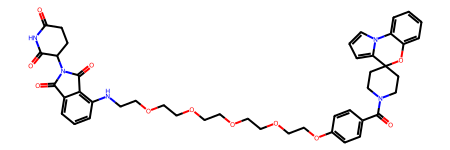

In [66]:
print(dataTable_cmpd[dataTable_cmpd['cmpd_id']==31093])
Chem.MolFromSmiles(dataTable_cmpd[dataTable_cmpd['cmpd_id']==31093]['Structure'].values[0])

       cmpd_id      mol_id                                          Structure
31104    31105  KT-0006911  O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCOCCOCCOCCOc4ccc...


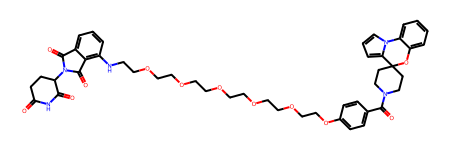

In [67]:
print(dataTable_cmpd[dataTable_cmpd['cmpd_id']==31105])
Chem.MolFromSmiles(dataTable_cmpd[dataTable_cmpd['cmpd_id']==31105]['Structure'].values[0])

In [ ]:
print(dataTable_rule_smi[dataTable_rule_smi['rule_smiles_id']==25376])
Chem.MolFromSmiles(dataTable_rule_smi[dataTable_rule_smi['rule_smiles_id']==25376]['smiles'].values[0])

In [ ]:
print(dataTable_rule_smi[dataTable_rule_smi['rule_smiles_id']==25376])
Chem.MolFromSmiles(dataTable_rule_smi[dataTable_rule_smi['rule_smiles_id']==25376]['smiles'].values[0])

In [ ]:
dataTable_constsmi[dataTable_constsmi['cmpd_id']==262813]

In [ ]:
dataTable_constsmi[dataTable_constsmi['cmpd_id']==262813]

In [ ]:
"KT_number_1", "smiles_1", 
"KT_number_2", "smiles_2", 

"property_name", "property_values_1", "property_values_2"


"rule_id"
"rule_from_smiles"
"rule_to_smiles"
"rule_constant_smiles"
"rule_Transformation" Position
"rule_env_avg"
"rule_env_count"
"rule_env_stats"
"rule_comments"

["smiles_1", "External_ID_1", "External_ID_2"]

In [ ]:
{"rule_environment_id": {"radius": 1, "num_pairs": 1}}

In [ ]:
## -------------------------------------------------------
## ---------------- load the rule data ----------------
## -------------------------------------------------------
## rule table
dataTable_rule = load_db_table(dataDict_csvFiles, db_table_name="rule", rename_cols={"id": "rule_id"})

## rule smiles
dataTable_rule_smi = load_db_table(dataDict_csvFiles, db_table_name="rule_smiles", usecols=['id', 'smiles'], rename_cols={'id': 'rule_smiles_id'})

## ----------- add the rule smiles info into rule table -----------
dataTable_rule = merge_cmpd_data(df_left=dataTable_rule, df_right=dataTable_rule_smi, left_on=['from_smiles_id', 'to_smiles_id'], right_on='rule_smiles_id')
dataTable_rule.drop(columns=["from_smiles_id", "to_smiles_id"], inplace=True)

## -------------------------------------------------------
## ----------- load the rule env data -----------
## -------------------------------------------------------
## rule env table
dataTable_rule_env = load_db_table(dataDict_csvFiles,
                                   db_table_name="rule_environment", 
                                   rename_cols={'id': 'rule_environment_id', 'num_pairs': 'rule_env_num_pairs', 'radius': 'rule_env_radius'})

## ----------- load the rule env stats data -----------
dataTable_rule_env_stats = load_db_table(dataDict_csvFiles,
                                         db_table_name="rule_environment_statistics",
                                         usecols=['rule_environment_id', 'property_name_id', 'count', 'avg', 'std', 'min', 'median', 'median'],
                                         rename_cols={})

#######################################################################################################
## ----------- merge rule env info -----------
dataTable_rule_env = dataTable_rule_env.merge(right=dataTable_rule, on="rule_id", how="left")
dataTable_rule_env = dataTable_rule_env.merge(right=dataTable_rule_env_stats, on="rule_environment_id", how="left")
dataTable_rule_env['property_name'] = dataTable_rule_env['property_name_id'].apply(lambda x: dataDict_propName[x])
dataTable_rule_env.head(3)

In [ ]:
dataTable_rule_env.head(20)

In [ ]:
dataTable_rule_env['']

In [ ]:
# {'id', 'environment_fingerprint_id'}

In [4]:
def Step_5_MMPs_DataClean(dataDict_tables, add_symetric=True):
    ## count time
    beginTime = time.time()
    print(f"5. Now clean up the MMPs data ...")
    ## ------------------------------------------------------------------

    ## get the individual database Tables
    dataTable_pair = dataDict_tables["pair"]
    dbTable_cmpd = dataDict_tables["compound"]
    dbTable_propName = dataDict_tables["property_name"]
    dbTable_propValue = dataDict_tables["compound_property"]

    ## ------------- build the dataDict of pairs -------------
    print(f"\tNow start cleanning up the dataDict of pairs ...\n")
    dataDict = {}
    for idx in dataTable_pair.index:
        pair_idx = dataTable_pair['id'][idx]
        cid_1 = int(dataTable_pair['compound1_id'][idx])
        cid_2 = int(dataTable_pair['compound2_id'][idx])
        const_id = dataTable_pair['constant_id'][idx]
        rule_env_id = dataTable_pair['rule_environment_id'][idx]

        ## initialize the sub-dict
        pair_info = f"{cid_1}==>{cid_2}"
        try:
            pair_list = sorted([cid_1, cid_2], reverse=False)
        except Exception as e:
            pass    
        
        if pair_info not in dataDict:
            ## add pair basic info
            dataDict[pair_info] = {}
            dataDict[pair_info]["pair_info"] = pair_info
            dataDict[pair_info]["pair_id"] = f"({min([cid_1, cid_2])},{max([cid_1, cid_2])})"
            dataDict[pair_info]["compound1_id"] = cid_1
            dataDict[pair_info]["compound2_id"] = cid_2
            dataDict[pair_info]["pair_detail"] = {}

            ## add compound info
            dataDict[pair_info]["From_mol_id"] = dbTable_cmpd['public_id'][cid_1]
            dataDict[pair_info]["To_mol_id"] = dbTable_cmpd['public_id'][cid_2]
            smi_1, smi_2 = dbTable_cmpd['input_smiles'][cid_1], dbTable_cmpd['input_smiles'][cid_2]
            dataDict[pair_info]["From_Structure"] = smi_1
            dataDict[pair_info]["To_Structure"] = smi_2
            
            ## add shared structure
            # dataDict[pair_info]["SharedSubstructure"] = fun_tbd(smi_1, smi_2)

            ## add compound prop info
            for prop_id in dbTable_propName.index:
                prop_name = dbTable_propName['name'][prop_id]
                dataDict[pair_info][f"From_{prop_name}"] = _findPropValue(dbTable_propValue, cid_1, prop_id, average=True)
                dataDict[pair_info][f"To_{prop_name}"] = _findPropValue(dbTable_propValue, cid_2, prop_id, average=True)
                ## add delta value change
                try:
                    delta_value = dataDict[pair_info][f"To_{prop_name}"] - dataDict[pair_info][f"From_{prop_name}"]
                except Exception as e:
                    delta_value = np.nan
                    
                dataDict[pair_info][f"Delta_{prop_name}"] = delta_value

        ## add pair details information (constant part)
        if const_id not in dataDict[pair_info]["pair_detail"]:
            dataDict[pair_info]["pair_detail"][const_id] = []
        
        ## add pair details information (rule_env)
        if rule_env_id not in dataDict[pair_info]["pair_detail"][const_id]:
            dataDict[pair_info]["pair_detail"][const_id].append(rule_env_id)
    print(f"\t\tOriginal num_pairs in dataDict: {len(dataDict)}\n")
    
    ## ------------- add the symetric pairs if not exist -------------
    tran_smi = True
    radius = 0    # [0, 1, 2, 3, 4, 5]
    sele_rule = "max"    # ["max", "min"]
    if tran_smi:
        for pair_info in dataDict:
            pair_detail = dataDict[pair_info]["pair_detail"]
            const_smi_sele, from_smiles, to_smiles = _findTranSmi(pair_detail, dataDict_tables, sele_rule=sele_rule, radius=radius)
            dataDict[pair_info]["constant_smiles"] = const_smi_sele
            dataDict[pair_info]["from_smiles"] = from_smiles
            dataDict[pair_info]["to_smiles"] = to_smiles
        
    ## ------------- add the symetric pairs if not exist -------------
    if add_symetric:
        print(f"\t\tNow adding symetric pairs ...")
        list_pair_info_4loop = copy.deepcopy(list(dataDict.keys()))
        list_pair_info_4check = copy.deepcopy(list(dataDict.keys()))
        for pair_info in list_pair_info_4loop:
            if pair_info in list_pair_info_4check:
                list_pair_info_4check.remove(pair_info)

                ## reverse pair
                cid_1, cid_2 = pair_info.split("==>")
                pair_info_revs = f"{cid_2}==>{cid_1}"
                if pair_info_revs in list_pair_info_4check:
                    list_pair_info_4check.remove(pair_info_revs)
                else:
                    ## if reversed pair not in check list, add it in the dict
                    dataDict[pair_info_revs] = {}
                    dataDict[pair_info_revs]["pair_info"] = pair_info_revs
                    dataDict[pair_info_revs]["pair_id"] = dataDict[pair_info]["pair_id"]
                    dataDict[pair_info_revs]["constant_smiles"] = dataDict[pair_info]["constant_smiles"]
                    dataDict[pair_info_revs]["pair_detail"] = {key: [] for key in dataDict[pair_info]["pair_detail"]}

                    dataDict[pair_info_revs]["From_mol_id"] = dataDict[pair_info]["To_mol_id"]
                    dataDict[pair_info_revs]["To_mol_id"] = dataDict[pair_info]["From_mol_id"]
                    dataDict[pair_info_revs]["From_Structure"] = dataDict[pair_info]["To_Structure"]
                    dataDict[pair_info_revs]["from_smiles"] = dataDict[pair_info]["to_smiles"]
                    dataDict[pair_info_revs]["to_smiles"] = dataDict[pair_info]["from_smiles"]
                    
                    for tmp_key in dataDict[pair_info]:
                        if tmp_key[0:6] == 'Delta_':
                            try:
                                delta_symetric = dataDict[pair_info][tmp_key] * -1
                            except Exception as e:
                                delta_symetric = np.nan
                            dataDict[pair_info_revs][tmp_key] = delta_symetric

                        elif tmp_key[0:5] == 'From_':
                            tmp_key_reverse = 'To_' + tmp_key[5:]
                            dataDict[pair_info_revs][tmp_key_reverse] = dataDict[pair_info][tmp_key]
                        
                        elif tmp_key[0:3] == "To_":
                            tmp_key_reverse = 'From_' + tmp_key[3:]
                            dataDict[pair_info_revs][tmp_key_reverse] = dataDict[pair_info][tmp_key]
                        else:
                            pass
            else:
                ## this pair was removed from check list because it's the revs pair of another pair
                pass
        print(f"\t\tNew num_pairs in symetric dataDict: {len(dataDict)}")
    
    ## ------------------------------------------------------------------
    costTime = time.time()-beginTime
    print(f"==> Step 5 <Final data clean> complete, costs time = %ds ................\n" % (costTime))
    return dataDict

In [ ]:
dataDict = Step_5_MMPs_DataClean(dataDict_tables, add_symetric=True)